In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)


In [15]:


import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy
import seaborn as sns
from neuromancer.loggers import BasicLogger
import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)


In [3]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1



In [4]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainU = train_sim['U'][:length].reshape(nbatch, nsteps, nu)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'r': trainX, 'xn': trainX[:, 0:1, :], 'u': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devU = dev_sim['U'][:length].reshape(nbatch, nsteps, nu)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'r': devX, 'xn': devX[:, 0:1, :], 'u': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nbatch*nsteps, nx)
    testU = test_sim['U'][:length].reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'r': testX, 'xn': testX[:, 0:1, :], 'u': testU}

    return train_loader, dev_loader, test_data


In [5]:
nsim = 1000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 50     # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)

In [6]:
theta_1 = library.PolynomialLibrary(nx, nu, 2)

theta_2_funs = [lambda X, u: torch.sqrt(X[:,0]), lambda X, u: torch.sqrt(X[:,1])]
theta_2_names = ["sqrt(x_0)", "sqrt(x_1)"]
theta_2 = library.FunctionLibrary(theta_2_funs, nx, nu, theta_2_names)


fx = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]))

In [7]:
integrator = integrators.Euler(fx, h=ts)
integrator_node = Node(integrator, ['xn', 'u'], ['x'])
x_bound = Node(lambda x: torch.clamp(x, xmin, xmax), ['x'], ['xn'])
dynamics_model = System([integrator_node, x_bound], nsteps=nsteps, name="dynamics_model")

In [8]:
# %% Constraints + losses:
x = variable("r")
xhat = variable('xn')[:, :-1, :]

# one step loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

#sparsity
l1 = variable([x], lambda x: torch.norm(list(fx.parameters())[0]))
loss_l1 = 0.00001*(l1 == 0)        #best so far



In [9]:


# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss, loss_l1]

# create constrained optimization loss
loss = PenaltyLoss(objectives, [])
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)



In [10]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=500,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=400,
    patience=200,
    logger=logger
)

None
Number of parameters: 34


In [64]:
for _ in range(6):
    train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps *= 2
    dynamics_model.nsteps = nsteps
    trainer.badcount = 0


epoch: 0	train_loss: 0.93026	dev_loss: 0.81743	eltime:  0.59821
epoch: 1	train_loss: 0.65756	dev_loss: 0.69719	eltime:  0.63939
epoch: 2	train_loss: 0.47963	dev_loss: 0.39020	eltime:  0.68213
epoch: 3	train_loss: 0.21634	dev_loss: 0.23848	eltime:  0.72104
epoch: 4	train_loss: 0.05028	dev_loss: 0.04622	eltime:  0.75849
epoch: 5	train_loss: 0.00973	dev_loss: 0.04497	eltime:  0.79726
epoch: 6	train_loss: 0.01069	dev_loss: 0.05818	eltime:  0.83995
epoch: 7	train_loss: 0.00602	dev_loss: 0.03200	eltime:  0.88117
epoch: 8	train_loss: 0.00327	dev_loss: 0.00873	eltime:  0.92305
epoch: 9	train_loss: 0.00216	dev_loss: 0.00484	eltime:  0.96671
epoch: 10	train_loss: 0.00299	dev_loss: 0.00420	eltime:  1.00698
epoch: 11	train_loss: 0.00227	dev_loss: 0.00242	eltime:  1.04780
epoch: 12	train_loss: 0.00135	dev_loss: 0.00284	eltime:  1.09143
epoch: 13	train_loss: 0.00182	dev_loss: 0.00139	eltime:  1.13151
epoch: 14	train_loss: 0.00095	dev_loss: 0.00148	eltime:  1.17219
epoch: 15	train_loss: 0.00104	dev_l

In [11]:
fx.load_state_dict(torch.load("saved_models/pt_SINDy_Model_20250312_205302.pth"))

/var/folders/7d/4w2xzdbj279fj424x2h2w2xh0000gn/T/ipykernel_4127/4216272395.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fx.load_state_dict(torch.load("saved_models/pt

<All keys matched successfully>

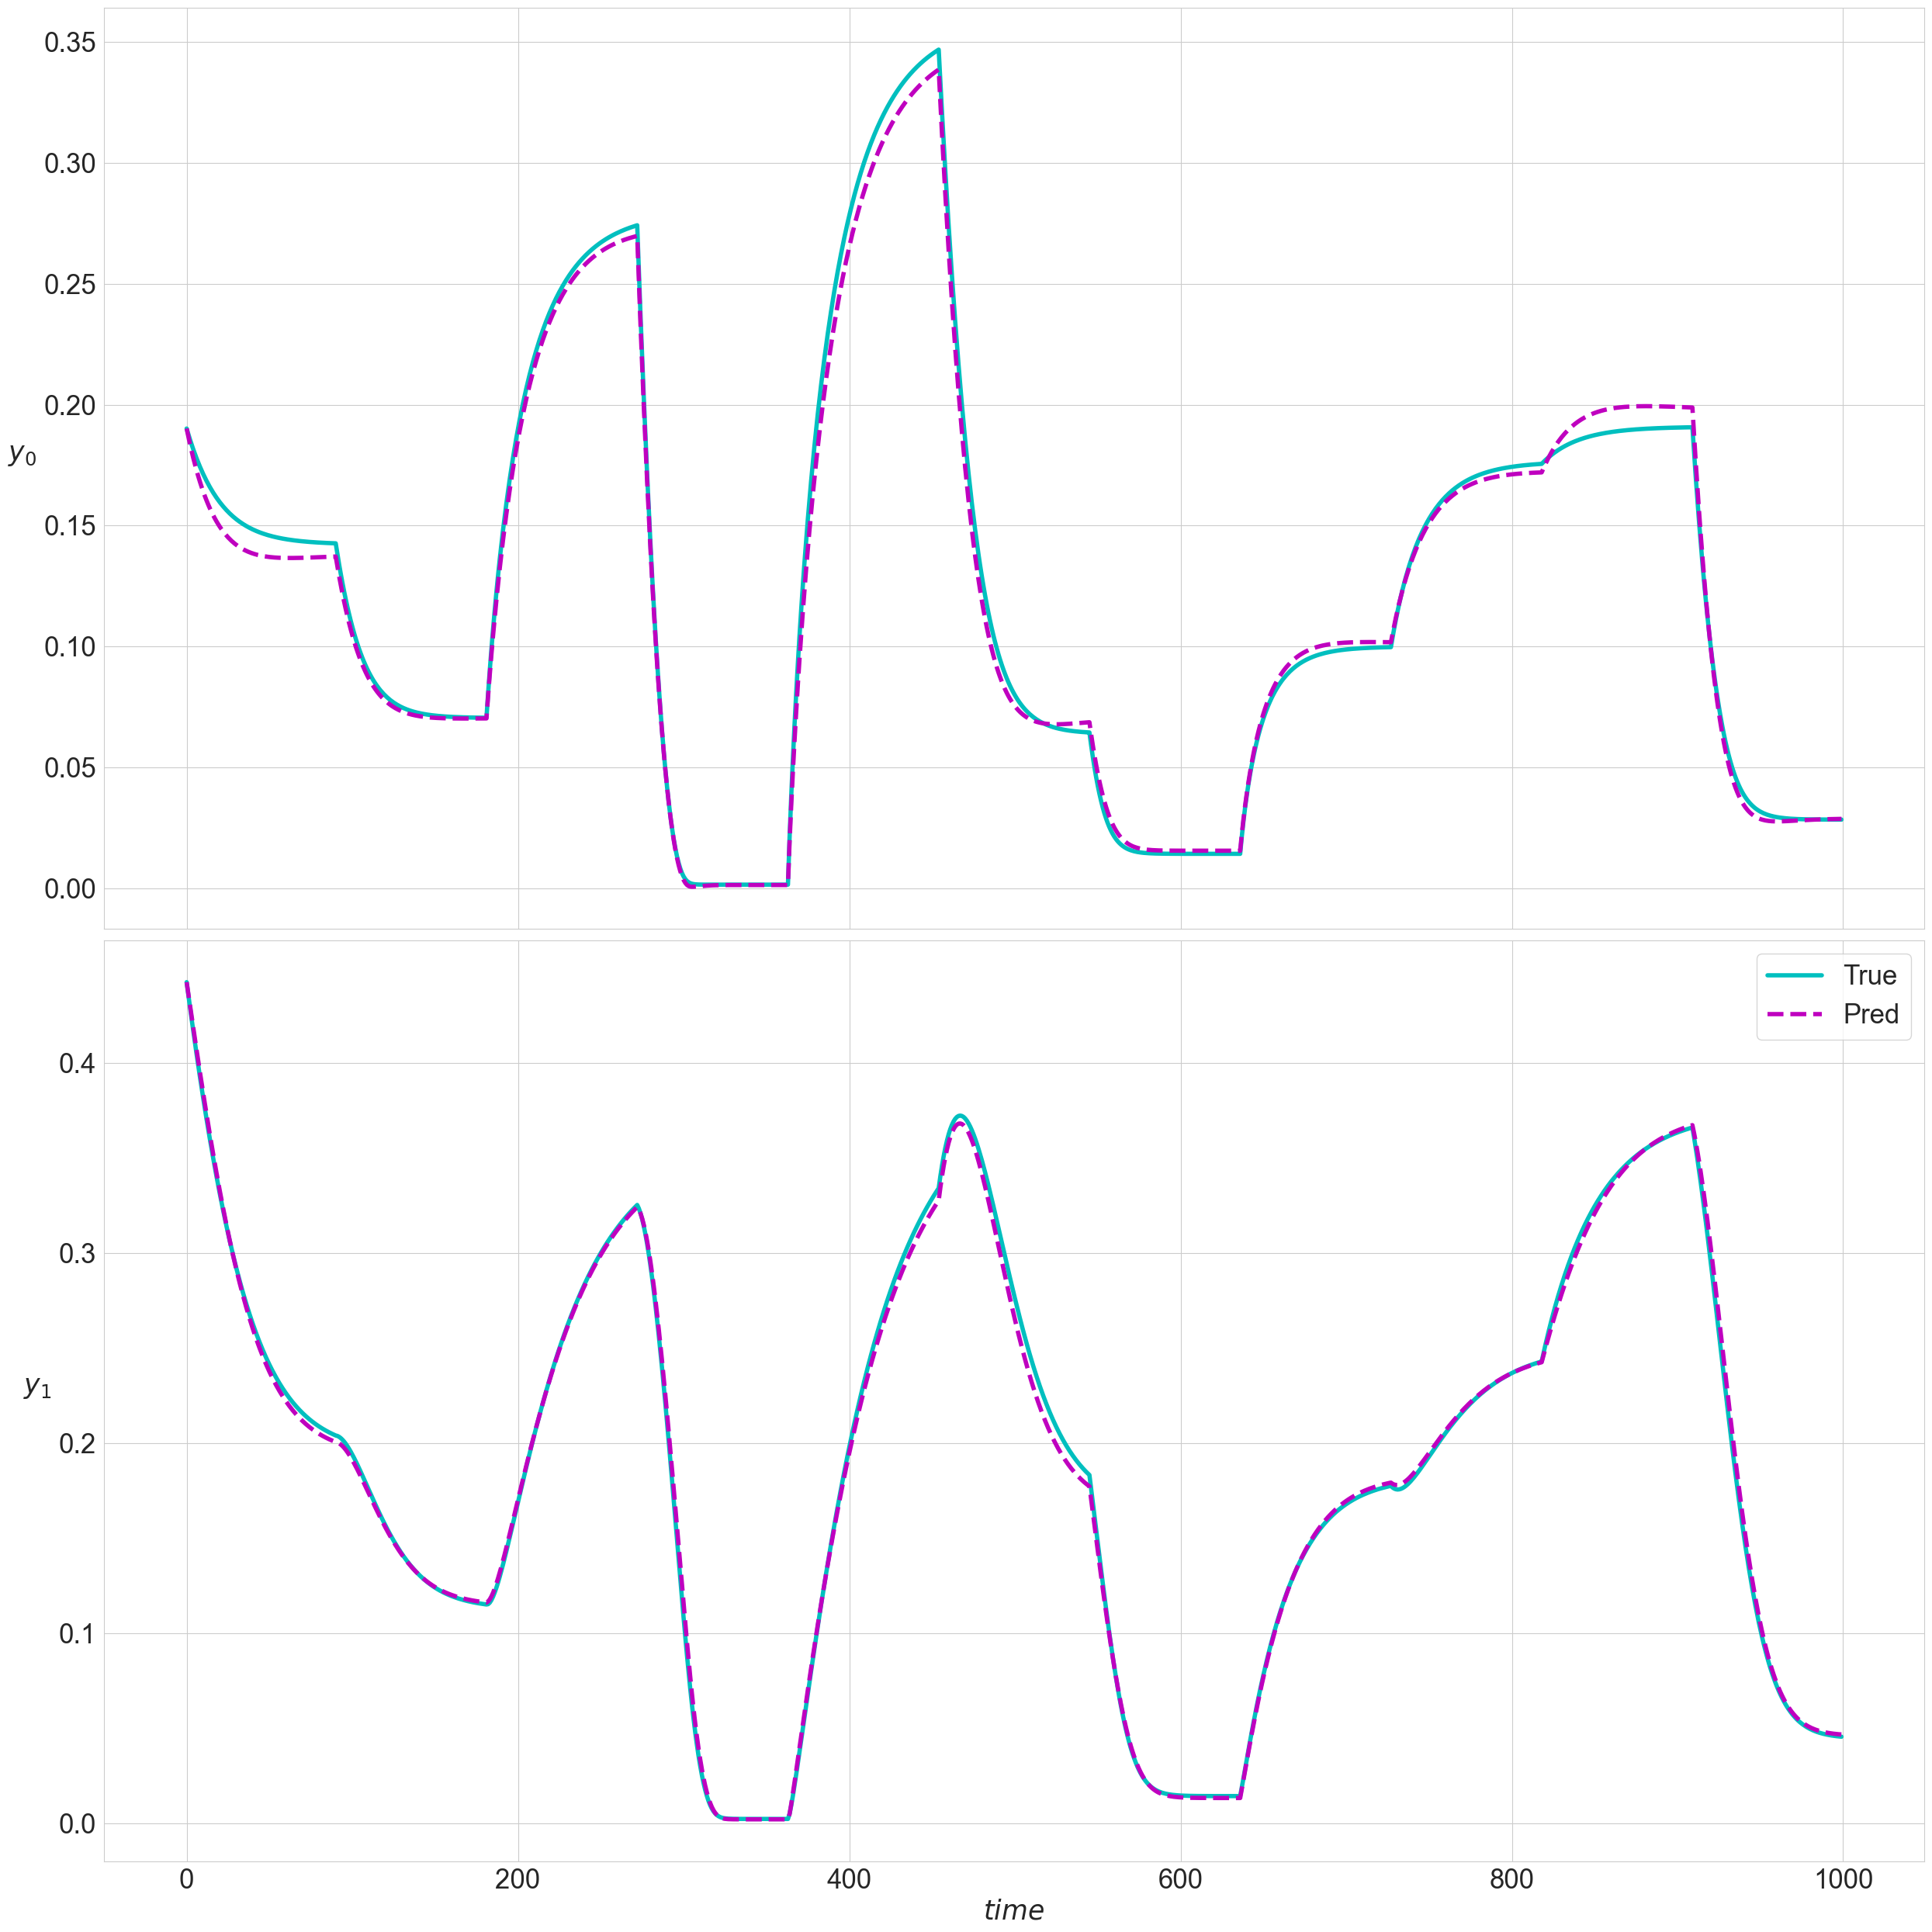

In [16]:
dynamics_model.nsteps = test_data['r'].shape[1]
test_output = dynamics_model(test_data)

pred_traj = test_output['xn'][:, :-1, :]
true_traj = test_data['r']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

sns.set_style("whitegrid")
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()


In [173]:
# from datetime import datetime
#
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
#
# # Generate timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# # Generate a valid filename with timestamp
# filename = "pt_SINDy_Model" + f"_{timestamp}.pth"
#
# # Define the full save path
# save_path = os.path.join(save_dir, filename)
#
# # Save the model state dictionary
# torch.save(fx.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_SINDy_Model_20250312_205302.pth


In [17]:
def threshold_filter(param, threshold):
    with torch.no_grad():  # Ensure no gradient tracking
        param.data = torch.where(torch.abs(param.data) < threshold, torch.tensor(0.0, device=param.device, dtype=param.dtype), param.data)

threshold = 0.0009
threshold_filter(fx.coef, threshold)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

coefficients = fx.coef.data.numpy()

def convert_to_latex(names):
    return [rf"${i.replace('*', ' ').replace('  ', ' ')}$" for i in names]
function_names_latex = convert_to_latex(fx.library.function_names)

control_terms_latex = [r"$dx_0$", r"$dx_1$"]



plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(coefficients.T, annot=True, xticklabels=function_names_latex, yticklabels=control_terms_latex, cmap="coolwarm", fmt=".2f", ax=ax)

ax.set_ylabel(r"\textbf{Control Terms}", fontsize=14, labelpad=10)
ax.set_xlabel(r"\textbf{Function Library}", fontsize=14, labelpad=10)
ax.set_title(r"\textbf{Coefficient Heatmap}", fontsize=14)

ax.xaxis.tick_top()  # Move x-axis ticks to the top first
ax.xaxis.set_label_position('bottom')  # Move label to the bottom
ax.tick_params(axis='x', bottom=False, top=False, labelbottom=True, labeltop=False)  # Enable bottom ticks, disable top
plt.xticks(rotation=0, ha='center')  # Keep x-axis labels horizontal

plt.tight_layout()
plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp3c7fx37u 0ba8326a3eac9c61fd8c2a9d5937a8c9.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0ba8326a3eac9c61fd8c2a9d5937a8c9.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(/usr/local/texlive/2025basic/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(/usr/local/texlive/2025basic/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2025basic/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmp3c7fx37u/0ba8326a3eac9c61fd8c2a9d5937a8c9.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpzhzfpyln 0ba8326a3eac9c61fd8c2a9d5937a8c9.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0ba8326a3eac9c61fd8c2a9d5937a8c9.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(/usr/local/texlive/2025basic/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(/usr/local/texlive/2025basic/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2025basic/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmpzhzfpyln/0ba8326a3eac9c61fd8c2a9d5937a8c9.log.




<Figure size 1500x200 with 2 Axes>

### SIDNy Policy

In [67]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank(seed=9)
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1.
sys = gt_model



In [68]:
def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Training dataset
    train_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                              'r': batched_ref}, name='train')

    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Development dataset
    dev_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                            'r': batched_ref}, name='dev')

    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader



In [69]:
nsteps = 10  # prediction horizon
n_samples = 3000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)

dx0/dt = 0.496*x_0 + 0.088*x_1 + 0.307*sin(x_0) + 0.490*sin(x_1) + 0.456*x_0 * x_1 + 0.349*r_0 + 0.022*r_1 + 0.294*r_0^2 + 0.698*r_1^2 + 0.161*x_0 * r_0 + 0.682*x_0 * r_1 + 0.397*x_1 * r_0 + 0.419*x_1 * r_1 
dx1/dt = 0.768*x_0 + 0.132*x_1 + 0.634*sin(x_0) + 0.896*sin(x_1) + 0.632*x_0 * x_1 + 0.402*r_0 + 0.169*r_1 + 0.519*r_0^2 + 0.800*r_1^2 + 0.282*x_0 * r_0 + 0.915*x_0 * r_1 + 0.874*x_1 * r_0 + 0.553*x_1 * r_1 



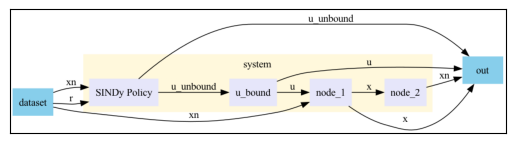

In [70]:
from library import FunctionLibrary
import itertools
torch.manual_seed(0)
# Number of features and control variables
n_features = nx
n_controls = nu

# Create an empty list for features and names
theta_funs = []
theta_names = []

# Degree 1 features (x_i)
theta_funs += [(lambda X, u, i=i: X[:, i]) for i in range(n_features)]
theta_names += [f"x_{i}" for i in range(n_features)]

# Sinusoidal features (sin(x_i))
theta_funs += [(lambda X, u, i=i: torch.sin(X[:, i])) for i in range(n_features)]
theta_names += [f"sin(x_{i})" for i in range(n_features)]

# # Product of x_i and sin(x_i)
# theta_funs += [(lambda X, u, i=i: X[:, i] * torch.sin(X[:, i])) for i in range(n_features)]
# theta_names += [f"x_{i} * sin(x_{i})" for i in range(n_features)]

#Quadratic interaction terms (x_i * x_j)
for i, j in itertools.combinations(range(n_features), 2):
    theta_funs.append(lambda X, u, i=i, j=j: X[:, i] * X[:, j])
    theta_names.append(f"x_{i} * x_{j}")


# Control inputs (u_i)
theta_funs += [(lambda X, u, i=i: u[:, i]) for i in range(n_controls)]
theta_names += [f"r_{i}" for i in range(n_controls)]

# Squared control inputs (u_i^2)
theta_funs += [(lambda X, u, i=i: u[:, i] ** 2) for i in range(n_controls)]
theta_names += [f"r_{i}^2" for i in range(n_controls)]

# Interaction terms (x_i * u_j)
theta_funs += [(lambda X, u, i=i, j=j: X[:, i] * u[:, j]) for i in range(n_features) for j in range(n_controls)]
theta_names += [f"x_{i} * r_{j}" for i in range(n_features) for j in range(n_controls)]

# Create function library
theta_library = FunctionLibrary(theta_funs, n_features, n_controls, theta_names)


# Create SINDy model
policy_sindy = sindy.SINDy(theta_library)
print(policy_sindy)

policy_node = Node(policy_sindy,  ['xn', 'r'], ['u_unbound'], name="SINDy Policy")
u_bound = Node(lambda u: torch.sigmoid(u) * (umax-umin) + umin, ['u_unbound'], ['u'], name="u_bound")

sindy_system = System([policy_node, u_bound, integrator_node, x_bound], nsteps=nsteps)
sindy_system.show()

In [71]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion

#sparsity
l1 = variable([x], lambda y: torch.norm(list(policy_node.parameters())[0], p=1))
loss_l1 = 0.001*(l1 == 0)

# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss, loss_l1]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]



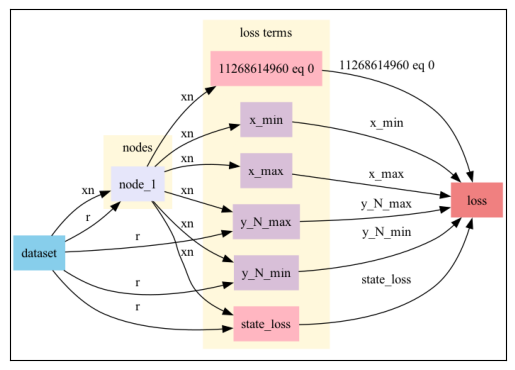

In [72]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [sindy_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [73]:
optimizer = torch.optim.AdamW(policy_node.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=1000,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
    patience=30,
    logger=logger
)

None
Number of parameters: 60


In [75]:
for _ in range(5):
    print(f'************   training with {nsteps} steps   ************   ')
    train_loader, dev_loader = get_policy_data(nsteps, n_samples)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps += 10
    sindy_system.nsteps = nsteps
    trainer.badcount = 0


************   training with 10 steps   ************   
epoch: 0	train_loss: 3.51661	dev_loss: 3.89495	eltime:  0.68370
epoch: 1	train_loss: 3.29922	dev_loss: 3.68588	eltime:  1.38105
epoch: 2	train_loss: 3.07177	dev_loss: 3.43706	eltime:  2.05535
epoch: 3	train_loss: 2.87610	dev_loss: 3.17551	eltime:  2.73233
epoch: 4	train_loss: 2.68532	dev_loss: 2.99336	eltime:  3.40886
epoch: 5	train_loss: 2.54918	dev_loss: 2.85682	eltime:  4.07316
epoch: 6	train_loss: 2.44233	dev_loss: 2.75255	eltime:  4.75115
epoch: 7	train_loss: 2.35863	dev_loss: 2.67210	eltime:  5.44692
epoch: 8	train_loss: 2.29192	dev_loss: 2.60824	eltime:  6.12655
epoch: 9	train_loss: 2.23702	dev_loss: 2.55592	eltime:  6.80139
epoch: 10	train_loss: 2.19089	dev_loss: 2.51256	eltime:  7.47460
epoch: 11	train_loss: 2.15215	dev_loss: 2.47605	eltime:  8.14764
epoch: 12	train_loss: 2.11888	dev_loss: 2.44492	eltime:  8.81996
epoch: 13	train_loss: 2.09023	dev_loss: 2.41799	eltime:  9.50135
epoch: 14	train_loss: 2.06523	dev_loss: 2.39

In [166]:
nsteps = 500
step_length = 100
torch.manual_seed(0)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=nsteps//step_length, rng=np.random.default_rng(seed=20))
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)

# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

In [167]:
# white-box ODE model with no-plant model mismatch
two_tank = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)
# integrate continuous time ODE
gt_integrator = integrators.RK4(two_tank, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
gt_integrator_node = Node(gt_integrator, ['xn', 'u'], ['x'], name='model')


In [168]:
import copy

gt_system_sindy_policy = copy.deepcopy(sindy_system)
gt_system_sindy_policy.nodes[2] = gt_integrator_node

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

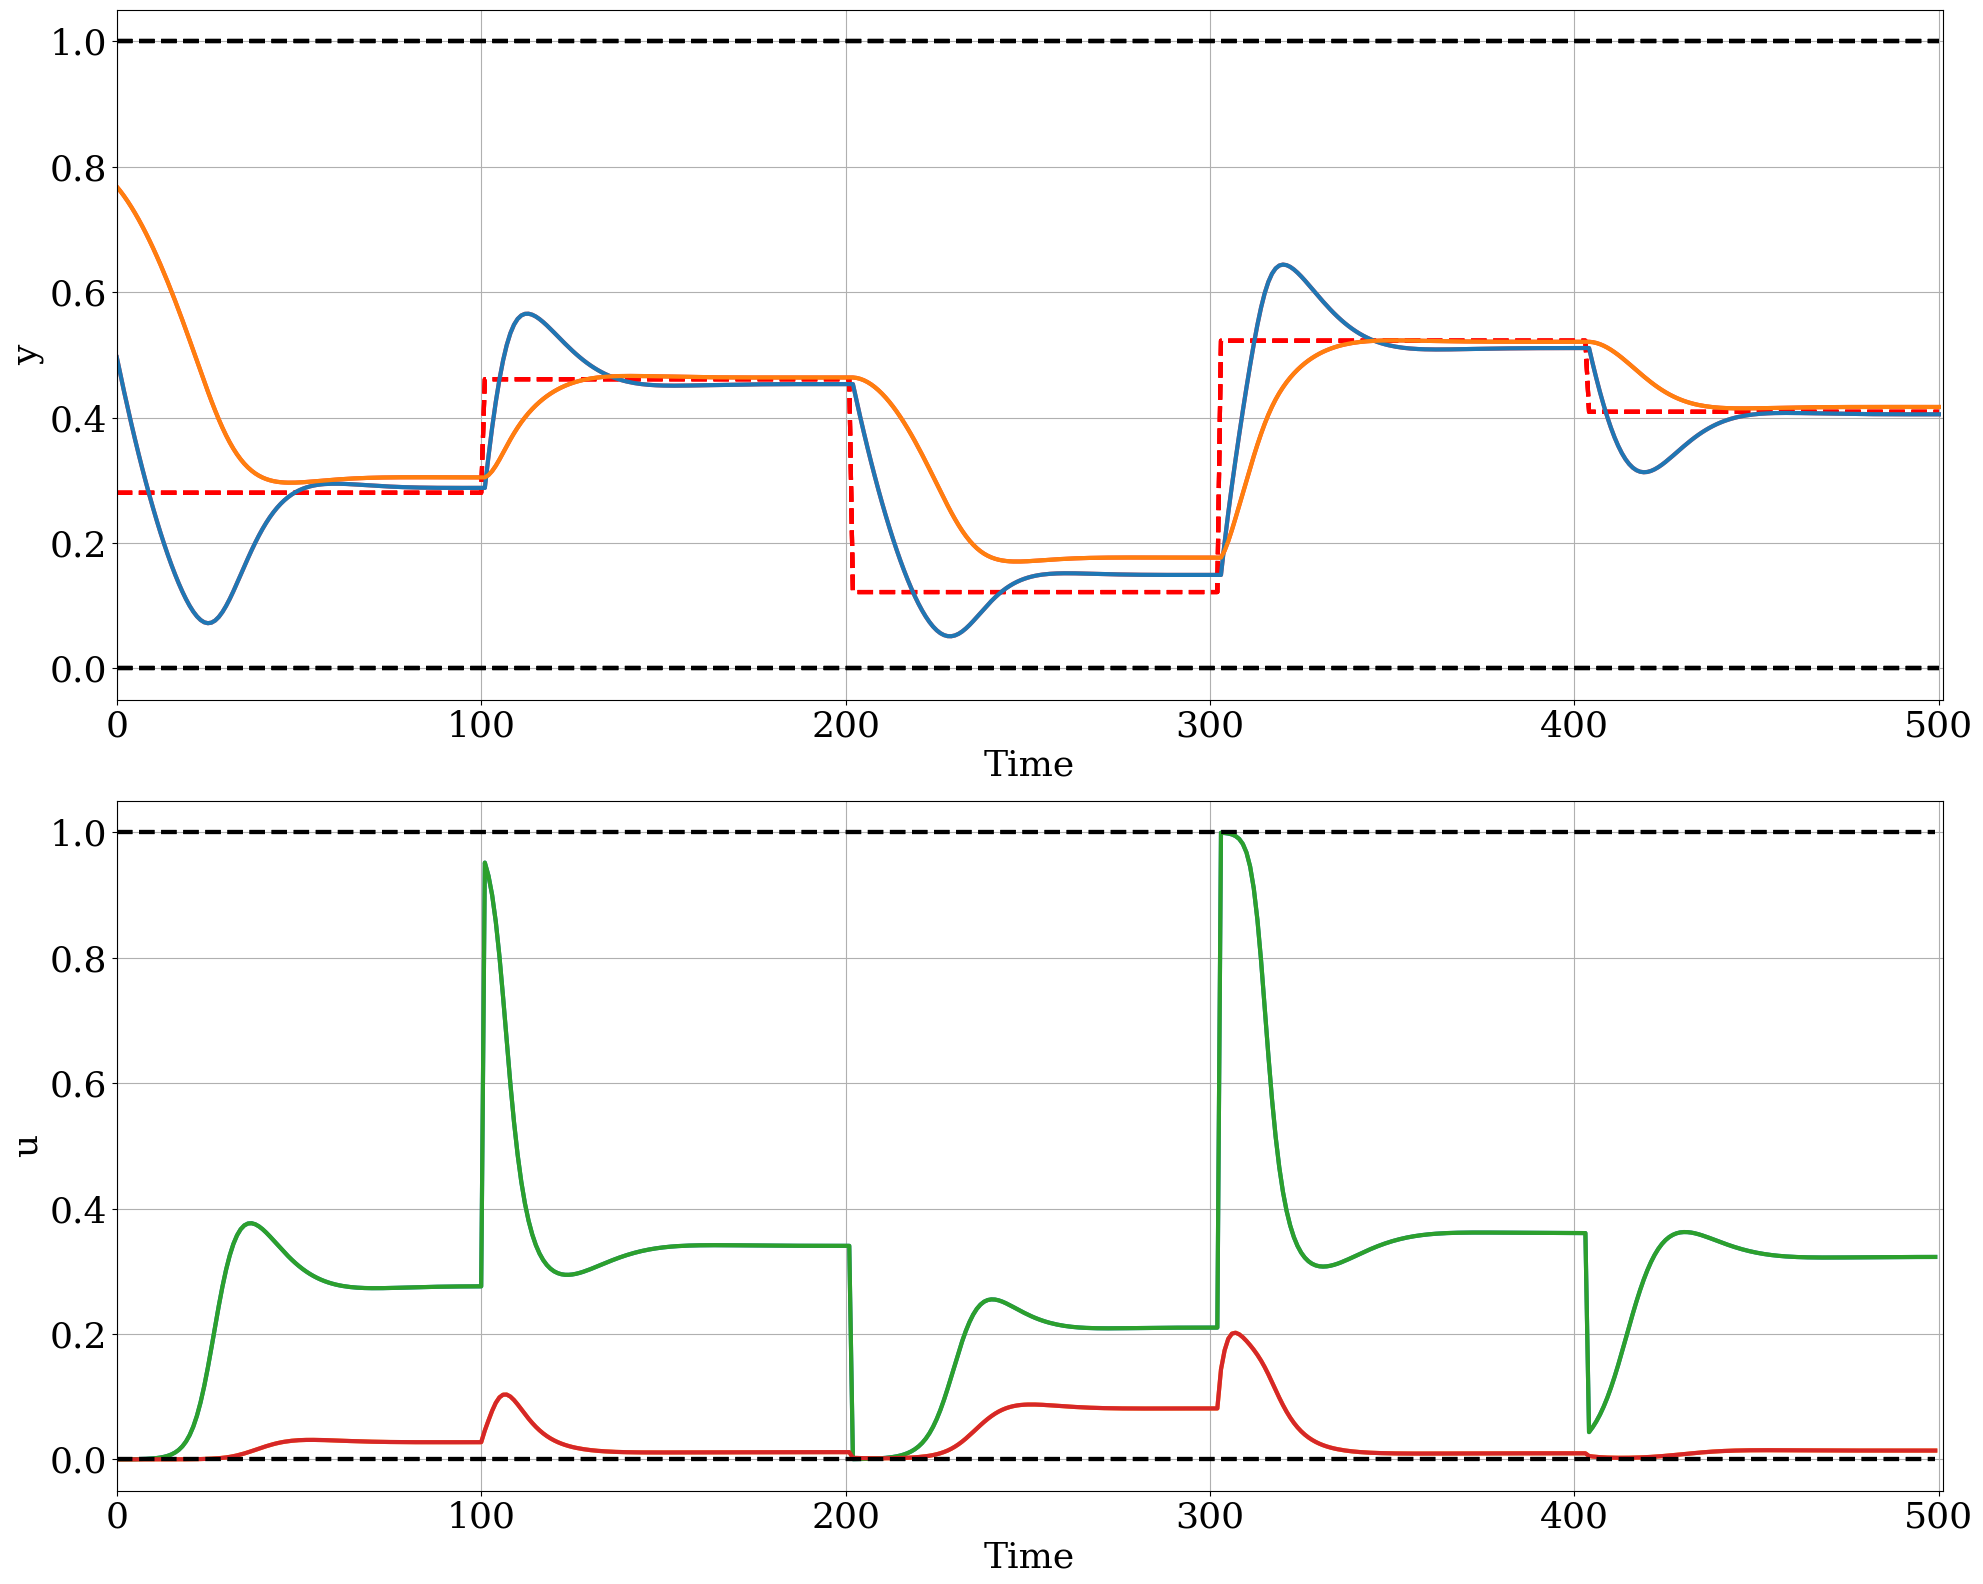

In [169]:
gt_system_sindy_policy.nsteps = nsteps
# perform closed-loop simulation
trajectories = gt_system_sindy_policy(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

In [85]:
print(policy_sindy)

dx0/dt = -5.949*x_0 + -9.116*x_1 + -7.157*sin(x_1) + -0.922*x_0 * x_1 + 9.962*r_0 + 9.950*r_1 + 1.352*r_0^2 + 1.366*r_1^2 + -0.232*x_0 * r_0 + -0.232*x_0 * r_1 
dx1/dt = 2.915*x_0 + -9.986*x_1 + -7.280*sin(x_1) + 0.089*r_0^2 + 0.088*r_1^2 + 4.973*x_0 * r_0 + 4.994*x_0 * r_1 



In [84]:
# from datetime import datetime
#
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
#
# # Generate timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# # Generate a valid filename with timestamp
# filename = "pt_policy_SINDY_SINDy_Model_" + "_".join(policy_sindy.library.function_names) + f"_{timestamp}.pth"
#
# # Define the full save path
# save_path = os.path.join(save_dir, filename)
#
# # Save the model state dictionary
# torch.save(policy_sindy.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_policy_SINDY_SINDy_Model_x_0_x_1_sin(x_0)_sin(x_1)_x_0 * x_1_r_0_r_1_r_0^2_r_1^2_x_0 * r_0_x_0 * r_1_x_1 * r_0_x_1 * r_1_20250312_132400.pth


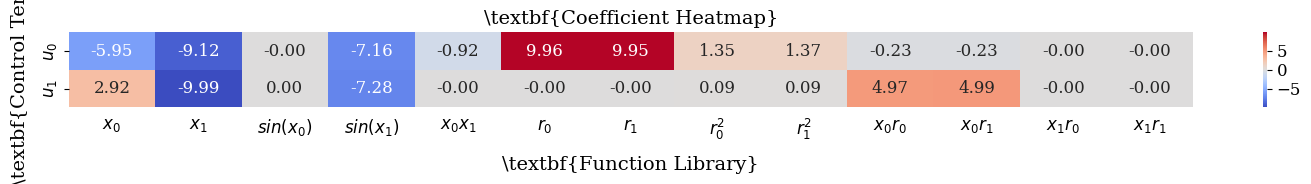

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

coefficients = policy_sindy.coef.data.numpy()

def convert_to_latex(names):
    return [rf"${i.replace('*', ' ').replace('  ', ' ')}$" for i in names]
function_names_latex = convert_to_latex(policy_sindy.library.function_names)

control_terms_latex = [r"$u_0$", r"$u_1$"]



plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 12
})

fig, ax = plt.subplots(figsize=(15, 2))
sns.heatmap(coefficients.T, annot=True, xticklabels=function_names_latex, yticklabels=control_terms_latex, cmap="coolwarm", fmt=".2f", ax=ax)

ax.set_ylabel(r"\textbf{Control Terms}", fontsize=14, labelpad=10)
ax.set_xlabel(r"\textbf{Function Library}", fontsize=14, labelpad=10)
ax.set_title(r"\textbf{Coefficient Heatmap}", fontsize=14)

ax.xaxis.tick_top()  # Move x-axis ticks to the top first
ax.xaxis.set_label_position('bottom')  # Move label to the bottom
ax.tick_params(axis='x', bottom=False, top=False, labelbottom=True, labeltop=False)  # Enable bottom ticks, disable top
plt.xticks(rotation=0, ha='center')  # Keep x-axis labels horizontal

plt.tight_layout()
plt.show()

### Neural Policy On SINDy Dynamics

In [122]:
# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy_neural = Node(net, ['xn', 'r'], ['u'], name='neural policy')


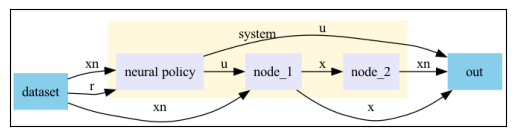

In [123]:
nsteps = 10
neural_sindy_system = System([policy_neural, integrator_node, x_bound], nsteps=nsteps)
neural_sindy_system.show()

In [124]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]


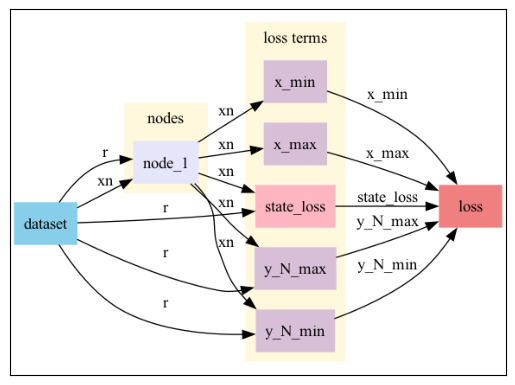

In [125]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [neural_sindy_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [126]:
optimizer = torch.optim.AdamW(policy_neural.parameters(), lr=0.002)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=1000,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
    patience=30,
    logger=logger
)

None
Number of parameters: 1316


In [127]:
for _ in range(5):
    print(f'************   training with {nsteps} steps   ************   ')
    train_loader, dev_loader = get_policy_data(nsteps, n_samples)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps += 10
    neural_sindy_system.nsteps = nsteps
    trainer.badcount = 0


************   training with 10 steps   ************   
epoch: 0	train_loss: 3.67627	dev_loss: 3.59104	eltime:  0.86020
epoch: 1	train_loss: 3.50342	dev_loss: 3.42557	eltime:  1.24462
epoch: 2	train_loss: 3.18001	dev_loss: 3.09937	eltime:  1.56663
epoch: 3	train_loss: 2.78453	dev_loss: 2.70514	eltime:  1.88750
epoch: 4	train_loss: 2.53241	dev_loss: 2.44382	eltime:  2.20131
epoch: 5	train_loss: 2.39322	dev_loss: 2.29576	eltime:  2.52156
epoch: 6	train_loss: 2.29498	dev_loss: 2.20414	eltime:  2.83877
epoch: 7	train_loss: 2.20216	dev_loss: 2.10300	eltime:  3.15438
epoch: 8	train_loss: 2.11647	dev_loss: 2.01627	eltime:  3.47350
epoch: 9	train_loss: 2.05544	dev_loss: 1.94736	eltime:  3.79227
epoch: 10	train_loss: 2.01234	dev_loss: 1.90042	eltime:  4.10987
epoch: 11	train_loss: 1.98178	dev_loss: 1.86890	eltime:  4.43015
epoch: 12	train_loss: 1.95743	dev_loss: 1.84301	eltime:  4.74737
epoch: 13	train_loss: 1.93414	dev_loss: 1.82027	eltime:  5.06283
epoch: 14	train_loss: 1.91657	dev_loss: 1.80

In [134]:
neural_sindy_system

System(
  (nodes): ModuleList(
    (0): neural policy(xn, r) -> u
    (1): node_1(xn, u) -> x
    (2): node_2(x) -> xn
  )
)

In [130]:
gt_system_neural_policy = copy.deepcopy(neural_sindy_system)
gt_system_neural_policy.nodes[1] = gt_integrator_node

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

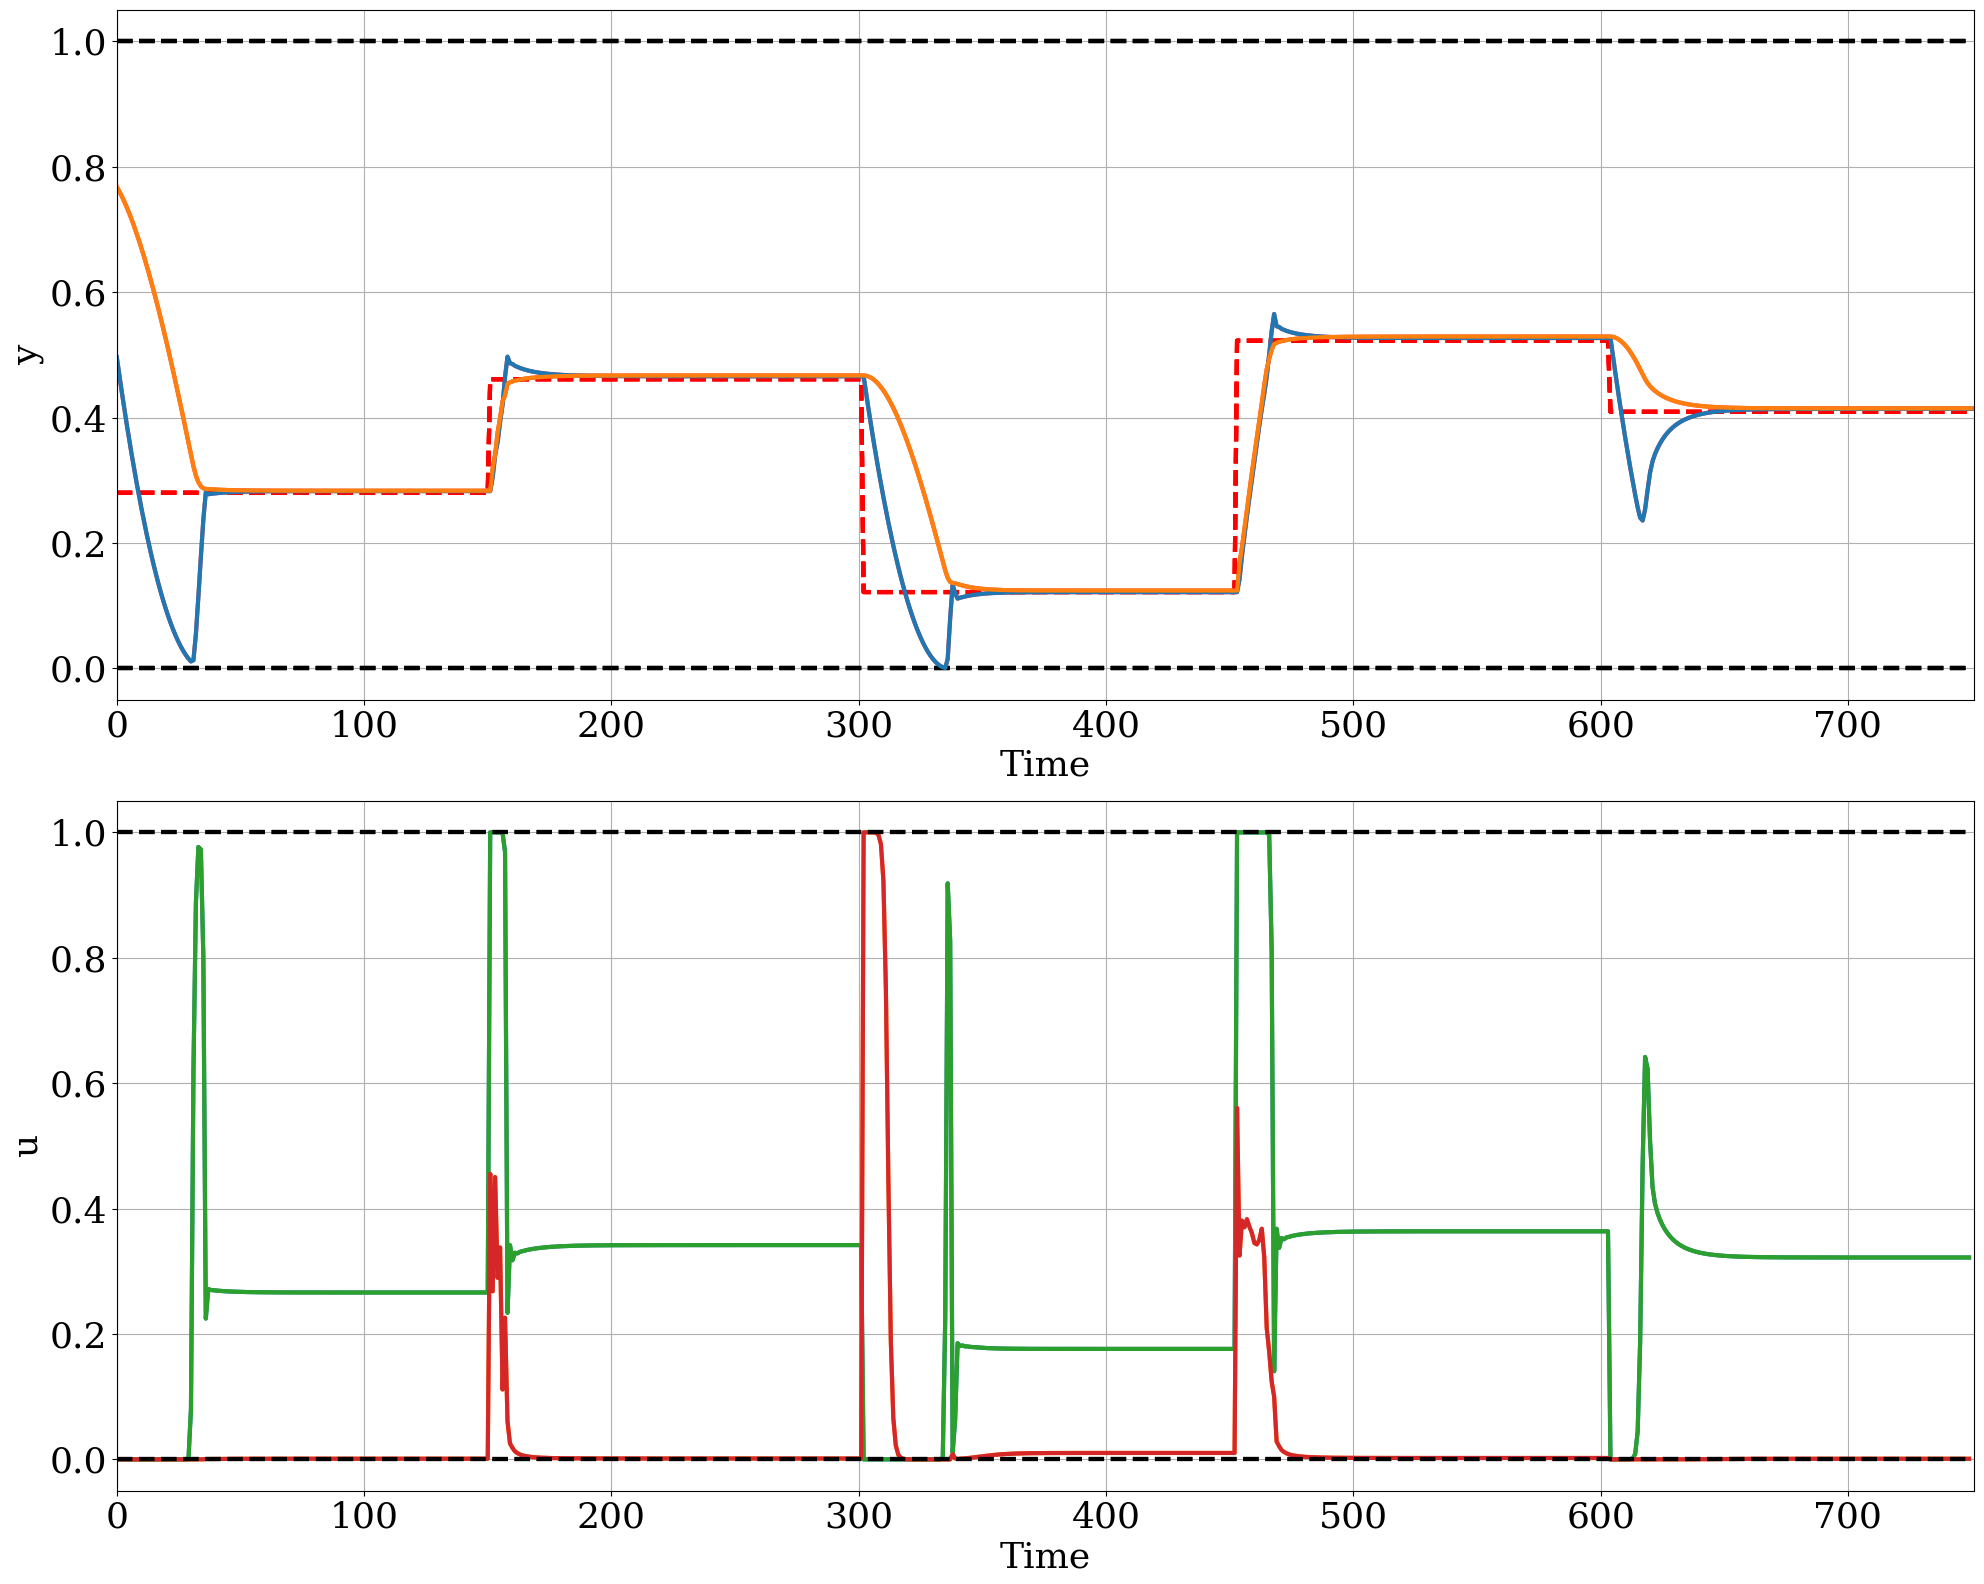

In [131]:
nsteps = 750
torch.manual_seed(0)
seed = 20
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

gt_system_neural_policy.nsteps = nsteps
# perform closed-loop simulation
trajectories = gt_system_neural_policy(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

In [133]:
# from datetime import datetime
#
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
#
# # Generate timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# # Generate a valid filename with timestamp
# filename = "pt_policy_Neural_SINDy_Model_" + f"_{timestamp}.pth"
#
# # Define the full save path
# save_path = os.path.join(save_dir, filename)
#
# # Save the model state dictionary
# torch.save(policy_sindy.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_policy_Neural_SINDy_Model__20250312_145106.pth


In [160]:
import time
import pickle
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

def trajectory_dump(nsteps, step_length, cl_system, policy_name:str, dynamics_name:str):

    # generate reference
    np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=nsteps//step_length, rng=np.random.default_rng(seed=20))
    R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
    torch_ref = torch.cat([R, R], dim=-1)
    torch.manual_seed(0)
    # generate initial data for closed loop simulation
    data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
            'r': torch_ref}

    cl_system.nsteps = nsteps

    print(data['r'].shape)

    times = []
    trajectories = None

    for i in range(50):
        start = time.time()
        # perform closed-loop simulation
        trajectories = cl_system(data)
        end = time.time() - start
        times.append(end)

    traj = dict()
    traj['traj'] = trajectories
    traj['times'] = times
    filename = policy_name + "_" + dynamics_name + ".pkl"
    save_path = os.path.join(save_dir, filename)

    with open(save_path, "wb") as f:
        pickle.dump(traj, f)


In [161]:
trajectory_dump(nsteps=500, step_length=100, cl_system=gt_system_neural_policy, policy_name="policy_NN", dynamics_name="dynamics_SINDy")

torch.Size([1, 501, 2])


In [162]:
policy_name = "policy_NN"
dynamics_name = "dynamics_SINDy"
filename = policy_name + "_" + dynamics_name + ".pkl"
save_dir = "results"
save_path = os.path.join(save_dir, filename)


In [163]:
with open(save_path, "rb") as f:
    loaded_data = pickle.load(f)


In [164]:
loaded_data["traj"]['xn']

tensor([[[0.4963, 0.7682],
         [0.4685, 0.7610],
         [0.4415, 0.7532],
         ...,
         [0.4138, 0.4146],
         [0.4138, 0.4146],
         [0.4138, 0.4146]]], requires_grad=True)

In [165]:

trajectory_dump(nsteps=500, step_length=100, cl_system=gt_system_sindy_policy, policy_name="policy_Sparse", dynamics_name="dynamics_SINDy")

torch.Size([1, 501, 2])
